# Stable Diffusion with 🤗 Diffusers

## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [8]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, DDIMScheduler, LMSDiscreteScheduler
from fastcore.all import concat
from huggingface_hub import notebook_login
from torchvision import transforms as tfms
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

logging.disable(logging.WARNING)

#torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [9]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [10]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [11]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [12]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
#scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

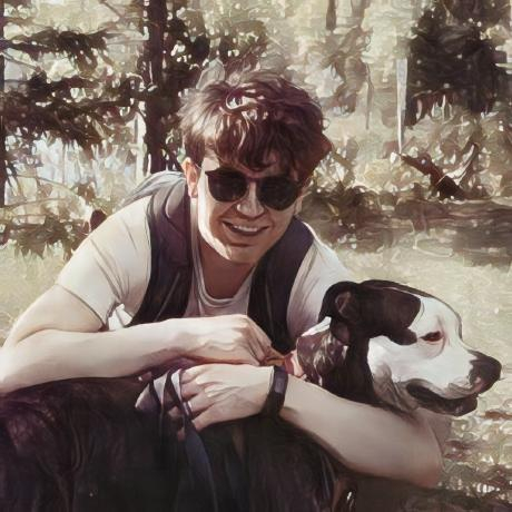

In [13]:
input_image = Image.open('alex_ruby_sketch.jpg').resize((512, 512))
input_image

In [14]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode((tfms.ToTensor()(input_im).unsqueeze(0).to("cuda")*2-1).half()) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [15]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

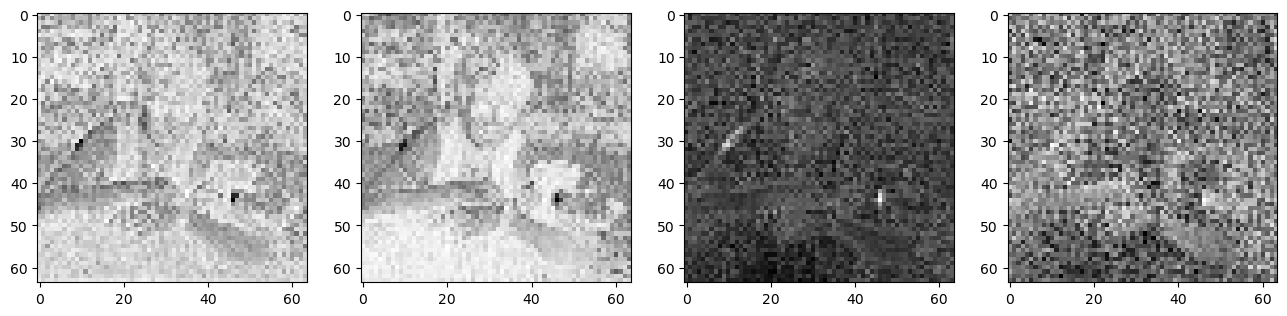

In [16]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

In [17]:
height = 512
width = 512
#num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [18]:
t = torch.tensor([0.5 * scheduler.config.num_train_timesteps]).to("cuda").half()
sigma = scheduler.sigmas[int(t) - 1]

In [68]:
def image_plus_noise():
    encoded = pil_to_latent(input_image)
    noise = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8))
    noise = noise.to("cuda").half()
    return scheduler.add_noise(encoded, noise, t)

prompt = ["a man and a dog with a leafy background"]
image_description = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
description_embeddings = text_encoder(image_description.input_ids.to("cuda"))[0].half()

max_length = image_description.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()

edit_prompt = ["a man and a dog with a night sky background"]
edit_description = tokenizer(edit_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
edit_embeddings = text_encoder(edit_description.input_ids.to("cuda"))[0].half()

description_cat_embeddings = torch.cat([description_embeddings, uncond_embeddings])
edit_cat_embeddings = torch.cat([edit_embeddings, uncond_embeddings])

def get_pred(cat_embeddings):
    latents = torch.cat([image_plus_noise()] * 2)
    latents = scheduler.scale_model_input(latents, t)

    with torch.no_grad():
        pred_guide, pred_uncond = unet(latents, t, encoder_hidden_states=cat_embeddings).sample.chunk(2)

    pred = pred_uncond + guidance_scale * (pred_guide - pred_uncond)
    
    return scheduler.step(pred, t, latents[:1]).pred_original_sample

pred_description = get_pred(description_cat_embeddings)
pred_edit = get_pred(edit_cat_embeddings)

In [89]:
n = 10
diff = []
for i in range(n):
    orig_noisy = get_pred(description_cat_embeddings)
    target_noisy = get_pred(edit_cat_embeddings)
    diff.append(vae.decode(1 / 0.18215 * (orig_noisy-target_noisy)).sample[0].detach().cpu())

In [100]:
mask = torch.stack(diff).sum(dim=0) / n

mask_min = mask.min()
mask_max = mask.max()
rescaled_0_to_1 = (mask - mask_min) / (mask_max - mask_min)

binarized = (rescaled_0_to_1 > 0.5).int()

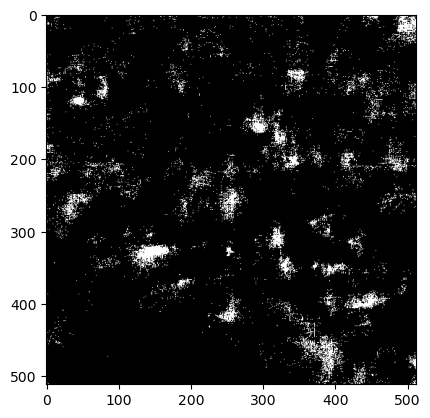

In [113]:
plt.imshow(binarized.float().mean(axis=0).int(), cmap="gray")